In [20]:
import os
import pandas as pd
from urllib.parse import parse_qs
import matplotlib.pyplot as plt
from IPython.display import display, HTML

In [21]:
url = "output_file_0=output_dynamic_libraries.csv&output_file_1=output_baseline_libraries.csv&output_file_2=output_baseline_cedar.csv&output_file_3=output_dynamic_cedar.csv&output_file_4=output_baseline_DafnyVMC.csv&output_file_5=output_dynamic_DafnyVMC.csv"
url2 = "output_file_0=.%2Fresults_llm%2Foutput_static_libraries.csv&output_file_1=.%2Fresults_llm%2Foutput_placeholder_libraries.csv&output_file_2=.%2Fresults_llm%2Foutput_placeholder_cedar.csv&output_file_3=.%2Fresults_llm%2Foutput_static_cedar.csv&output_file_4=.%2Fresults_llm%2Foutput_placeholder_DafnyVMC.csv&output_file_5=.%2Fresults_llm%2Foutput_dynamic_DafnyVMC.csv&output_file_6=.%2Fresults_llm%2Foutput_static_DafnyVMC.csv"
RESULT_PATH = "/exp/dafny_repair/results_llm/"

# Main evaluation dashboard

In [34]:
# parse the url
parsed2 = parse_qs(url2)
parsed = parse_qs(url)

In [23]:
def get_type_output_file(filename):
    type_analysis = filename.split("_")[1]
    return type_analysis


def get_benchmarck_name(filename):
    type_analysis = filename.split("_")[2].split(".")[0]
    return type_analysis


def get_ouput_files(dir):
    """
    Return all the filenames in the directory that start by output_
    """
    files = os.listdir(dir)
    return [f for f in files if f.startswith("output_")]

In [35]:
results = {}
# for el, file_list in parsed.items():
for filename in get_ouput_files(RESULT_PATH):
    type_analysis = get_type_output_file(filename)
    benchmark_name = get_benchmarck_name(filename)
    df = pd.read_csv(RESULT_PATH + filename)
    results[(type_analysis, benchmark_name)] = df
    # print(f"Type analysis: {type_analysis}, Benchmark: {benchmark_name}")
    # display(df["New Method Result"].value_counts())

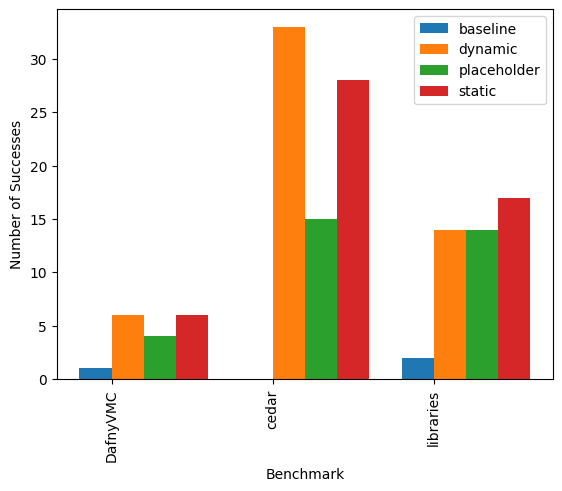

In [31]:
import numpy as np

# Initialize a dictionary to store the number of successes for each method and benchmark
success_counts = {}

# Iterate over the results dictionary
for (method, benchmark), df in results.items():
    # Count the number of successes
    # Assuming 'New Method Result' column indicates success if it equals 'Success'
    success_count = int((df["New Method Result"] == "Correct").sum())

    # Add the count to the dictionary
    if benchmark not in success_counts:
        success_counts[benchmark] = {}
    success_counts[benchmark][method] = success_count

# Get a sorted list of benchmarks and methods
benchmarks = sorted(success_counts.keys())
methods = sorted(
    set(method for counts in success_counts.values() for method in counts.keys())
)

# Create a grouped bar plot
bar_width = 0.2
index = np.arange(len(benchmarks))

for i, method in enumerate(methods):
    plt.bar(
        index + i * bar_width,
        [success_counts[benchmark].get(method, 0) for benchmark in benchmarks],
        bar_width,
        label=method,
    )

plt.xlabel("Benchmark")
plt.ylabel("Number of Successes")
plt.xticks(
    index + bar_width / 2, benchmarks, rotation=90
)  # Rotate the x-axis labels for better readability
plt.legend()  # Show legend
plt.show()

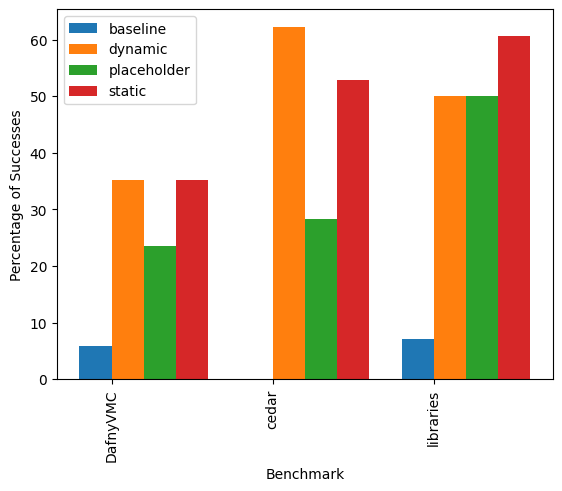

In [32]:
import numpy as np

# Initialize a dictionary to store the number of successes for each method and benchmark
success_counts = {}
total_counts = {}

# Iterate over the results dictionary
for (method, benchmark), df in results.items():
    # Count the number of successes
    success_count = int((df["New Method Result"] == "Correct").sum())
    total_count = df["Index"].nunique()  # Count the number of unique indices

    # Add the counts to the dictionaries
    if benchmark not in success_counts:
        success_counts[benchmark] = {}
        total_counts[benchmark] = {}
    success_counts[benchmark][method] = success_count
    total_counts[benchmark][method] = total_count

# Get a sorted list of benchmarks and methods
benchmarks = sorted(success_counts.keys())
methods = sorted(
    set(method for counts in success_counts.values() for method in counts.keys())
)

# Create a grouped bar plot
bar_width = 0.2
index = np.arange(len(benchmarks))

for i, method in enumerate(methods):
    # Calculate the percentage of successes
    percentages = [
        100.0
        * success_counts[benchmark].get(method, 0)
        / total_counts[benchmark].get(method, 1)
        for benchmark in benchmarks
    ]
    plt.bar(index + i * bar_width, percentages, bar_width, label=method)

plt.xlabel("Benchmark")
plt.ylabel("Percentage of Successes")
plt.xticks(
    index + bar_width / 2, benchmarks, rotation=90
)  # Rotate the x-axis labels for better readability
plt.legend()  # Show legend
plt.show()

## Table of success and failure for each assertion

In [27]:
# Initialize an empty dictionary to store the success and failure methods for each benchmark
methods = {}

# Iterate over the results dictionary
for (method, benchmark), df in results.items():
    # Group the DataFrame by index
    for index, group in df.groupby("Index"):
        # Check if there's at least one success
        if (group["New Method Result"] == "Correct").any():
            success_method = method
            fail_method = None
        else:
            success_method = None
            fail_method = method

        # Get the URL from the group
        url = group["Url"].iloc[0]  # Assuming all rows in the group have the same URL

        # Add the methods to the dictionary
        if benchmark not in methods:
            methods[benchmark] = {}
        if index not in methods[benchmark]:
            methods[benchmark][index] = {"Success": [], "Fail": []}
        if success_method:
            methods[benchmark][index]["Success"].append(
                '<a href="{}">{}</a>'.format(url, success_method)
            )
        if fail_method:
            methods[benchmark][index]["Fail"].append(
                '<a href="{}">{}</a>'.format(url, fail_method)
            )

# Convert the dictionary to a DataFrame
df_methods = pd.DataFrame.from_dict(
    {(i, j): methods[i][j] for i in methods.keys() for j in methods[i].keys()},
    orient="index",
)

# Convert the DataFrame to HTML and display it
df_methods = df_methods.to_html(escape=False)
display(HTML(df_methods))